In [6]:
# Download dataset
!kaggle datasets download -d emmarex/plantdisease

# Unzip the downloaded file
!unzip plantdisease.zip

Streaming output truncated to the last 5000 lines.
  inflating: plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08c033bd-fbc3-445a-88d1-1863070e52ce___YLCV_GCREC 2872.JPG  
  inflating: plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08dd176c-e9d9-4746-92c3-fa8dc9074347___UF.GRC_YLCV_Lab 03057.JPG  
  inflating: plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08f78a80-46f5-45a6-937c-4d05d61c08c2___UF.GRC_YLCV_Lab 01895.JPG  
  inflating: plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0903aa95-6e8a-4abd-a003-126fcd9a5493___YLCV_GCREC 2806.JPG  
  inflating: plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0911d416-d73d-4c2a-8e45-207a7ceb7c9a___YLCV_GCREC 2773.JPG  
  inflating: plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/09188838-cc89-4925-94c5-d9563c4cb4bf___UF.GRC_YLCV_Lab 02974.JPG  
  inflating: plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0922e026-b563-438d-b9ed-74

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from datetime import datetime
import os
from PIL import Image
import torchvision.transforms.functional as TF

In [8]:
# Data transformations with data augmentation
# Perform feature engineering to improve model performance
transform = transforms.Compose([
    transforms.Resize(255),
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomRotation(10),  # Randomly rotate the image by up to 10 degrees
    transforms.CenterCrop(224),
    transforms.ToTensor()
])


In [9]:
data_dir = 'PlantVillage'
dataset = datasets.ImageFolder(data_dir, transform=transform)

In [10]:
# Split dataset into training, validation, and test sets
indices = list(range(len(dataset)))
split = int(np.floor(0.85 * len(dataset)))
validation = int(np.floor(0.70 * split))

np.random.shuffle(indices)
train_indices, validation_indices, test_indices = (
    indices[:validation],
    indices[validation:split],
    indices[split:],
)

train_sampler = SubsetRandomSampler(train_indices)
validation_sampler = SubsetRandomSampler(validation_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_loader = torch.utils.data.DataLoader(dataset, sampler=train_sampler, batch_size=32)
validation_loader = torch.utils.data.DataLoader(dataset, sampler=validation_sampler, batch_size=32)
test_loader = torch.utils.data.DataLoader(dataset, sampler=test_sampler, batch_size=32)

In [11]:
# Number of classes in the dataset
targets_size = len(dataset.class_to_idx)


In [12]:
# Research and choose appropriate models
# Custom CNN model
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 28 * 28, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

custom_cnn = CustomCNN(targets_size)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
custom_cnn.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_custom_cnn = torch.optim.Adam(custom_cnn.parameters(), lr=0.001)


In [13]:
# Function to evaluate the model
def evaluate(model, dataloader, criterion):
    model.eval()
    loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss += criterion(outputs, targets).item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    accuracy = 100. * correct / total
    return loss / len(dataloader), accuracy


In [14]:
# Function to train the model
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.sampler)
        val_loss, val_accuracy = evaluate(model, val_loader, criterion)
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')


In [15]:
# Implement a baseline model and evaluate it
# Train and evaluate the custom CNN model
train_model(custom_cnn, train_loader, validation_loader, criterion, optimizer_custom_cnn, num_epochs=10)
val_loss, val_accuracy = evaluate(custom_cnn, validation_loader, criterion)
print(f'Custom CNN - Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')


Epoch 1/10, Train Loss: 1.6630, Validation Loss: 0.9166, Validation Accuracy: 68.74%
Epoch 2/10, Train Loss: 0.8182, Validation Loss: 0.6314, Validation Accuracy: 78.05%
Epoch 3/10, Train Loss: 0.5818, Validation Loss: 0.4282, Validation Accuracy: 85.26%
Epoch 4/10, Train Loss: 0.4606, Validation Loss: 0.3970, Validation Accuracy: 86.70%
Epoch 5/10, Train Loss: 0.3777, Validation Loss: 0.3363, Validation Accuracy: 88.87%
Epoch 6/10, Train Loss: 0.3323, Validation Loss: 0.3297, Validation Accuracy: 89.13%
Epoch 7/10, Train Loss: 0.2937, Validation Loss: 0.2605, Validation Accuracy: 91.32%
Epoch 8/10, Train Loss: 0.2488, Validation Loss: 0.2757, Validation Accuracy: 90.80%
Epoch 9/10, Train Loss: 0.2232, Validation Loss: 0.2524, Validation Accuracy: 91.92%
Epoch 10/10, Train Loss: 0.1867, Validation Loss: 0.3424, Validation Accuracy: 89.68%
Custom CNN - Validation Loss: 0.3397, Validation Accuracy: 90.02%


In [16]:
# Use cross-validation to check model reliability
from sklearn.model_selection import KFold

def cross_validate_model(model, dataset, criterion, k=5):
    kfold = KFold(n_splits=k, shuffle=True)
    results = []
    for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
        train_sampler = SubsetRandomSampler(train_idx)
        val_sampler = SubsetRandomSampler(val_idx)
        train_loader = torch.utils.data.DataLoader(dataset, sampler=train_sampler, batch_size=32)
        val_loader = torch.utils.data.DataLoader(dataset, sampler=val_sampler, batch_size=32)

        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

        val_loss, val_accuracy = evaluate(model, val_loader, criterion)
        results.append(val_accuracy)
        print(f'Fold {fold+1}, Validation Accuracy: {val_accuracy:.2f}%')

    print(f'Cross-Validation Results: {results}')
    print(f'Mean Accuracy: {np.mean(results):.2f}%, Std Dev: {np.std(results):.2f}%')


In [17]:
# Cross-validate the custom CNN model
cross_validate_model(custom_cnn, dataset, criterion, k=5)


Epoch 1/10, Train Loss: 0.2530, Validation Loss: 0.1468, Validation Accuracy: 94.67%
Epoch 2/10, Train Loss: 0.2150, Validation Loss: 0.1287, Validation Accuracy: 95.86%
Epoch 3/10, Train Loss: 0.1955, Validation Loss: 0.1779, Validation Accuracy: 94.21%
Epoch 4/10, Train Loss: 0.1653, Validation Loss: 0.1198, Validation Accuracy: 96.32%
Epoch 5/10, Train Loss: 0.1611, Validation Loss: 0.1330, Validation Accuracy: 96.05%
Epoch 6/10, Train Loss: 0.1481, Validation Loss: 0.1086, Validation Accuracy: 96.49%
Epoch 7/10, Train Loss: 0.1297, Validation Loss: 0.1507, Validation Accuracy: 95.74%
Epoch 8/10, Train Loss: 0.1250, Validation Loss: 0.1199, Validation Accuracy: 96.22%
Epoch 9/10, Train Loss: 0.1033, Validation Loss: 0.0954, Validation Accuracy: 97.00%
Epoch 10/10, Train Loss: 0.1268, Validation Loss: 0.1138, Validation Accuracy: 96.12%
Fold 1, Validation Accuracy: 96.27%
Epoch 1/10, Train Loss: 0.1428, Validation Loss: 0.0585, Validation Accuracy: 97.84%
Epoch 2/10, Train Loss: 0.12

In [20]:
# Batch gradient descent function
def batch_gd(model, criterion, optimizer, train_loader, validation_loader, epochs):
    train_losses = np.zeros(epochs)
    validation_losses = np.zeros(epochs)

    for e in range(epochs):
        t0 = datetime.now()
        train_loss = []
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()  # Corrected by adding optimizer parameter
            output = model(inputs)
            loss = criterion(output, targets)
            train_loss.append(loss.item())
            loss.backward()
            optimizer.step()

        train_loss = np.mean(train_loss)

        validation_loss = []
        for inputs, targets in validation_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            output = model(inputs)
            loss = criterion(output, targets)
            validation_loss.append(loss.item())

        validation_loss = np.mean(validation_loss)

        train_losses[e] = train_loss
        validation_losses[e] = validation_loss

        dt = datetime.now() - t0

        print(f"Epoch : {e+1}/{epochs} Train_loss:{train_loss:.3f} Test_loss:{validation_loss:.3f} Duration:{dt}")

    return train_losses, validation_losses


In [21]:
# Train with batch gradient descent

train_losses, validation_losses = batch_gd(custom_cnn, criterion, optimizer_custom_cnn, train_loader, validation_loader, 5)


Epoch : 1/5 Train_loss:0.021 Test_loss:0.008 Duration:0:01:04.101429
Epoch : 2/5 Train_loss:0.010 Test_loss:0.006 Duration:0:01:03.613325
Epoch : 3/5 Train_loss:0.011 Test_loss:0.025 Duration:0:01:03.250110
Epoch : 4/5 Train_loss:0.022 Test_loss:0.028 Duration:0:01:03.556698
Epoch : 5/5 Train_loss:0.019 Test_loss:0.008 Duration:0:01:03.461900


In [22]:
# Save and load model
torch.save(custom_cnn.state_dict(), 'plant_disease_model_1.pt')
custom_cnn.load_state_dict(torch.load("plant_disease_model_1.pt"))
custom_cnn.eval()

<ipython-input-22-012a5dfb5769>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  custom_cnn.load_state_dict(torch.load("plant_disease_model_1.pt"))


CustomCNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=100352, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=1024, out_features=15, bias=True)
  )
)

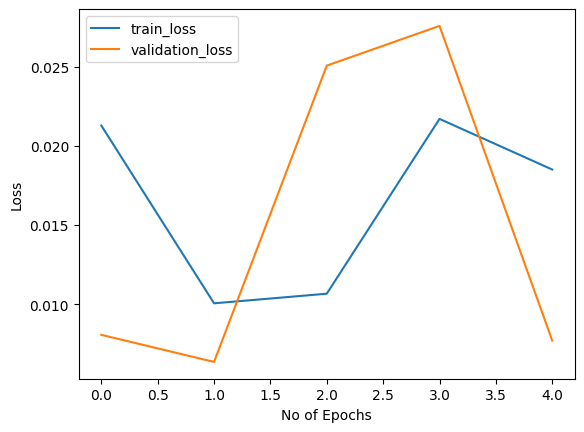

In [23]:
# Plot losses
plt.plot(train_losses, label='train_loss')
plt.plot(validation_losses, label='validation_loss')
plt.xlabel('No of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [25]:
# Accuracy function
def accuracy(model, loader):
    n_correct = 0
    n_total = 0
    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predictions = torch.max(outputs, 1)
        n_correct += (predictions == targets).sum().item()
        n_total += targets.shape[0]
    acc = n_correct / n_total
    return acc

# Calculate accuracies
train_acc = accuracy(custom_cnn, train_loader)
test_acc = accuracy(custom_cnn, test_loader)
validation_acc = accuracy(custom_cnn, validation_loader)

print(f"Train Accuracy : {train_acc}\nTest Accuracy : {test_acc}\nValidation Accuracy : {validation_acc}")

Train Accuracy : 0.9991041615766756
Test Accuracy : 0.999031007751938
Validation Accuracy : 0.99809994299829


In [26]:
# Transform index to disease
transform_index_to_disease = dataset.class_to_idx
transform_index_to_disease = dict([(value, key) for key, value in transform_index_to_disease.items()])


Original :  ntvillage/PlantVillage/Pepper__bell___Bacterial_spot/0022d6b7-d47c-4ee2-ae9a-392a53f48647___JR_B.Spot 8964
Pepper__bell___Bacterial_spot


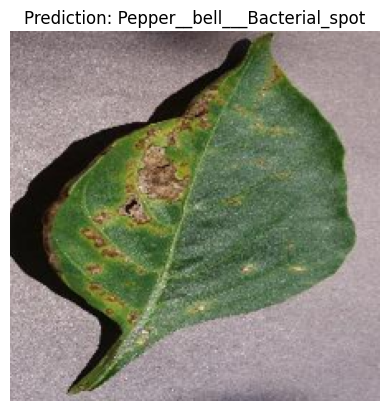

Original :  ntvillage/PlantVillage/Pepper__bell___Bacterial_spot/01613cd0-d3cd-4e96-945c-a312002037bf___JR_B.Spot 3262
Pepper__bell___Bacterial_spot


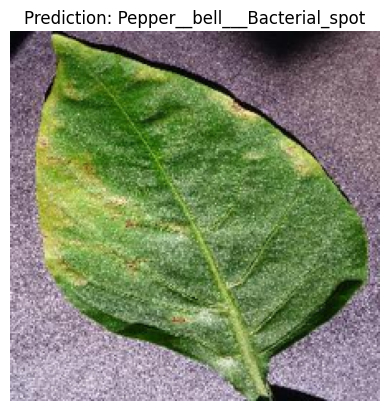

Original :  ntvillage/PlantVillage/Potato___Late_blight/0051e5e8-d1c4-4a84-bf3a-a426cdad6285___RS_LB 4640
Potato___Late_blight


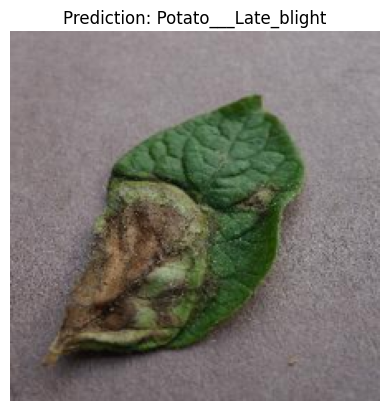

Original :  ntvillage/PlantVillage/Potato___Late_blight/01270f5c-a44b-4da7-9398-289088c197ab___RS_LB 2517
Tomato_Spider_mites_Two_spotted_spider_mite


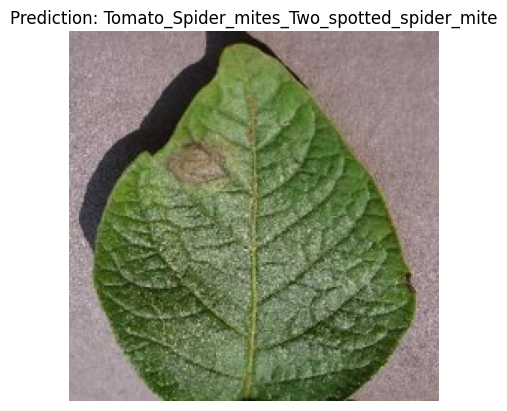

In [42]:
#Single prediction function
def single_prediction(model, image_path):
    image = Image.open(image_path)
    image = image.resize((224, 224))
    input_data = TF.to_tensor(image)
    input_data = input_data.view((-1, 3, 224, 224))
    input_data = input_data.to(device)
    model.eval()
    output = model(input_data)
    output = output.cpu().detach().numpy()
    index = np.argmax(output)
    print("Original : ", image_path[12:-4])
    pred_label = transform_index_to_disease[index]
    print(pred_label)

    # Display the image and prediction
    plt.imshow(image)
    plt.title(f"Prediction: {pred_label}")
    plt.axis('off')  # Turn off axis labels
    plt.show()


# Test single predictions

test_image_paths = [
    '/content/plantvillage/PlantVillage/Pepper__bell___Bacterial_spot/0022d6b7-d47c-4ee2-ae9a-392a53f48647___JR_B.Spot 8964.JPG', # Added comma here
    '/content/plantvillage/PlantVillage/Pepper__bell___Bacterial_spot/01613cd0-d3cd-4e96-945c-a312002037bf___JR_B.Spot 3262.JPG', # Added comma here
    '/content/plantvillage/PlantVillage/Potato___Late_blight/0051e5e8-d1c4-4a84-bf3a-a426cdad6285___RS_LB 4640.JPG',
    '/content/plantvillage/PlantVillage/Potato___Late_blight/01270f5c-a44b-4da7-9398-289088c197ab___RS_LB 2517.JPG'
]

for image_path in test_image_paths:
    try:
        single_prediction(custom_cnn, image_path)
    except FileNotFoundError as e:
        print(f"Error: {e}")